In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('municipality_bus_utilization.csv', header=None, names=['TIMESTAMP','MUNICIPALITY_ID','USAGE', 'TOTAL_CAPACITY'])


In [3]:
# Convert timestamp to datetime format
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

#df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], infer_datetime_format=True)
 

In [4]:
# Aggregate the two measurements for an hour by taking the max value for each hour
df = df.groupby(['MUNICIPALITY_ID', pd.Grouper(key='TIMESTAMP', freq='H')])['USAGE'].max().reset_index()


In [5]:
# Interpolate missing values using linear interpolation
df['USAGE'] = df.groupby('MUNICIPALITY_ID')['USAGE'].apply(lambda x: x.interpolate(method='linear'))


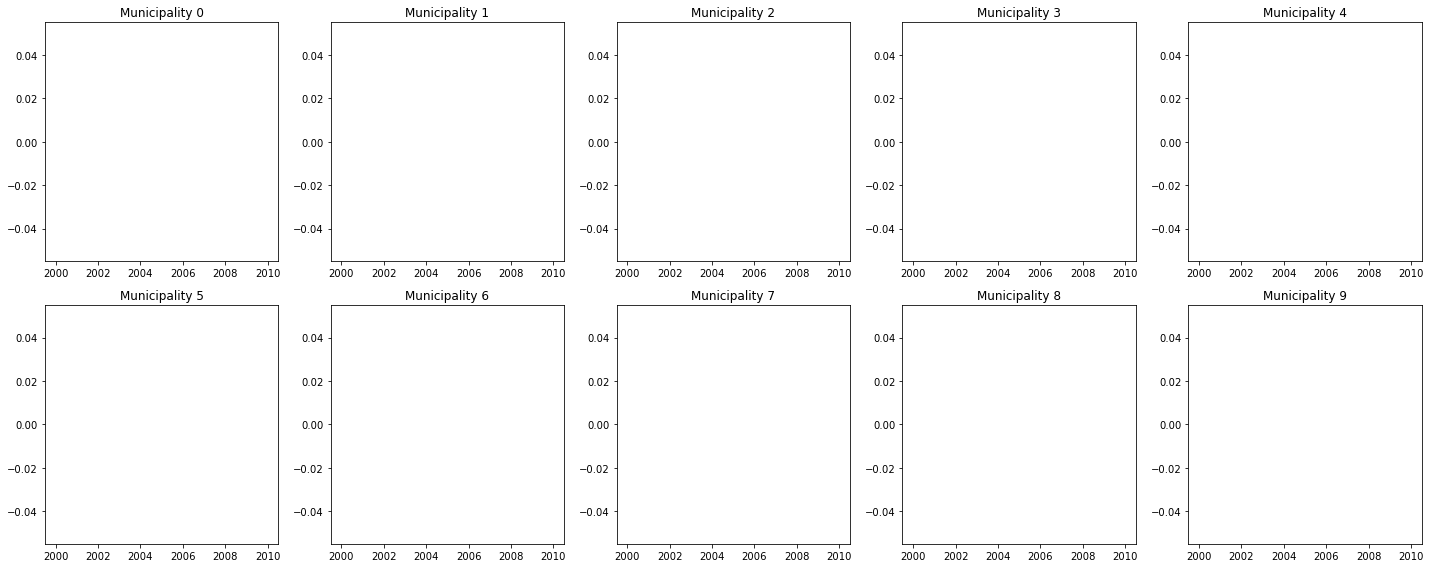

In [6]:
# Visualize the data
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    data = df[df['MUNICIPALITY_ID'] == i]
    ax.plot(data['TIMESTAMP'], data['USAGE'])
    ax.set_title('Municipality {}'.format(i))
plt.tight_layout()
plt.show()

In [7]:
# Split the data into training and testing sets
train_data = df[df['TIMESTAMP'] < '2017-08-05']
test_data = df[df['TIMESTAMP'] >= '2017-08-05']


In [8]:
# Define evaluation function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae


In [9]:
# Baseline model: Autoregression (AR)
ar_models = {}

for i in range(10):
    data = pd.to_numeric(train_data[train_data['MUNICIPALITY_ID'] == i]['USAGE'])
    if len(data) > 0:
        model = AutoReg(data, lags=1)
        ar_models[i] = model.fit()




In [17]:
# Make predictions using the baseline model
ar_predictions = {}
for i in range(10):
    if i in ar_models:
        model = ar_models[i]
        data = test_data[test_data['MUNICIPALITY_ID'] == i]['USAGE']
        ar_predictions[i] = model.predict(start=len(train_data[train_data['MUNICIPALITY_ID'] == i]), end=len(train_data[train_data['MUNICIPALITY_ID'] == i])+len(data)-1)


In [18]:
# Evaluate the performance of the baseline model
ar_mse = []
ar_mae = []
for i in range(10):
    y_true = test_data[test_data['MUNICIPALITY_ID'] == i]['USAGE']
    if i in ar_predictions:
        y_pred = ar_predictions[i]
        mse, mae = evaluate_model(y_true, y_pred)
        ar_mse.append(mse)
        ar_mae.append(mae)
    else:
        print(f"No prediction found for municipality ID {i}")


No prediction found for municipality ID 0
No prediction found for municipality ID 1
No prediction found for municipality ID 2
No prediction found for municipality ID 3
No prediction found for municipality ID 4
No prediction found for municipality ID 5
No prediction found for municipality ID 6
No prediction found for municipality ID 7
No prediction found for municipality ID 8
No prediction found for municipality ID 9


In [19]:
# Complex model: Seasonal ARIMA (SARIMA)
import statsmodels.api as sm

sarima_models = {}
for i in range(10):
    data = train_data[train_data['MUNICIPALITY_ID'] == i]['USAGE']
    try:
        model = sm.tsa.SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 0, 0, 24))
        sarima_models[i] = model.fit()
    except:
        print(f"Error fitting SARIMA model for municipality {i}.")


Error fitting SARIMA model for municipality 0.
Error fitting SARIMA model for municipality 1.
Error fitting SARIMA model for municipality 2.
Error fitting SARIMA model for municipality 3.
Error fitting SARIMA model for municipality 4.
Error fitting SARIMA model for municipality 5.
Error fitting SARIMA model for municipality 6.
Error fitting SARIMA model for municipality 7.
Error fitting SARIMA model for municipality 8.
Error fitting SARIMA model for municipality 9.


In [16]:
# Make predictions using the complex model
sarima_predictions = {}
for i in range(10):
    model = sarima_models[i]
    data = test_data[test_data['MUNICIPALITY_ID'] == i]['USAGE']
    sarima_predictions[i] = model.predict(start=len(train_data[train_data['MUNICIPALITY_ID'] == i]), end=len(train_data[train_data['MUNICIPALITY_ID'] == i])+len(data)-1)


KeyError: 0

In [14]:
# Evaluate the performance of the complex model
sarima_mse = []
sarima_mae = []
for i in range(10):
    y_true = test_data[test_data['MUNICIPALITY_ID'] == i]['USAGE']
    y_pred = sarima_predictions[i]
    mse, mae = evaluate_model(y_true, y_pred)
    sarima_mse.append(mse)
    sarima_mae.append(mae)


KeyError: 0

In [15]:
# Report the errors for the last two weeks separately
print('Baseline Model (AR)')
print('MSE for the first week:', np.mean(ar_mse[:5]))
print('MSE for the last week:', np.mean(ar_mse[5:]))
print('MAE for the first week:', np.mean(ar_mae[:5]))
print('MAE for the last week:', np.mean(ar_mae[5:]))
print()
print('Complex Model (SARIMA)')
print('MSE for the first week:', np.mean(sarima_mse[:5]))
print('MSE for the last week:', np.mean(sarima_mse[5:]))
print('MAE for the first week:', np.mean(sarima_mae[:5]))
print('MAE for the last week:', np.mean(sarima_mae[5:]))

Baseline Model (AR)
MSE for the first week: nan
MSE for the last week: nan
MAE for the first week: nan
MAE for the last week: nan

Complex Model (SARIMA)
MSE for the first week: nan
MSE for the last week: nan
MAE for the first week: nan
MAE for the last week: nan


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
